--- SparkSession Created and Data Loaded ---
--- Data Aggregated by Route ---
--- Feature Engineering for Clustering Complete ---
--- Training SOM (10x10 grid)... ---
--- SOM Training Complete ---


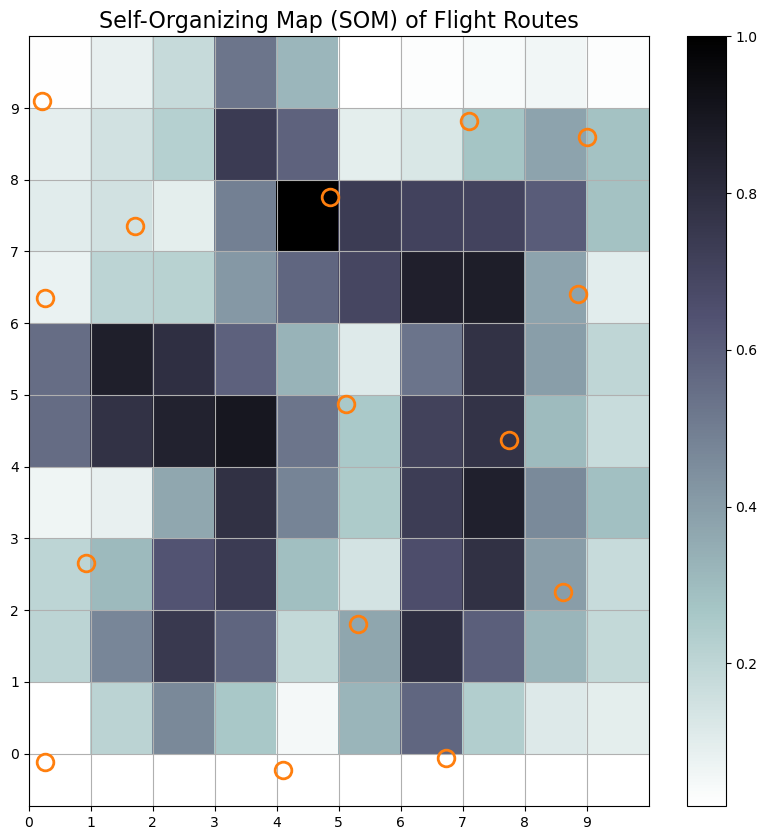

In [1]:
# ===================================================================
# === SCRIPT: COMPLETE SOM IMPLEMENTATION (WITH DATA PREP) ========
# ===================================================================

# === Imports ===
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, avg, first, concat_ws
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
import numpy as np
from minisom import MiniSom # Import the library
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# === Step 1: Install MiniSom (if not already done in this environment) ===
# %pip install MiniSom 
# Note: You might need to run this line once, then restart the kernel before running the rest.

# === Step 2: Setup Spark and Load Data ===
spark = SparkSession.builder.appName("FlightPulse-SOM-Clustering").getOrCreate()
df = spark.read.csv("flights.csv", header=True, inferSchema=True)
print("--- SparkSession Created and Data Loaded ---")

# === Step 3: Feature Engineering & Aggregation ===
df_with_features = df.withColumn(
    "route", concat_ws("-", col("DEPARTURE_STATION_CD"), col("ARRIVAL_STATION_CD"))
).withColumn(
    "TotalSeats", col("FIRST_CLASS_SEATS") + col("BUSINESS_CLASS_SEATS") + col("ECONOMY_SEATS")
).withColumn(
    "TotalPax", col("TIER1_ELIGIBLE_PAX") + col("TIER2_ELIGIBLE_PAX") + col("TIER3_ELIGIBLE_PAX")
)

route_dna = df_with_features.groupBy("route").agg(
    count("*").alias("FlightFrequency"),
    first("HAUL").alias("HaulType"),
    avg("TotalSeats").alias("AvgTotalSeats"),
    (avg(col("FIRST_CLASS_SEATS") + col("BUSINESS_CLASS_SEATS")) / (avg("TotalSeats") + 1e-6)).alias("PremiumSeatRatio"),
    (avg(col("TIER1_ELIGIBLE_PAX")) / (avg("TotalPax") + 1e-6)).alias("Tier1PassengerRatio")
)
print("--- Data Aggregated by Route ---")

# === Step 4: Prepare Data for SOM (Scaling is crucial) ===
categorical_cols = ["HaulType"]
numerical_cols = ["FlightFrequency", "AvgTotalSeats", "PremiumSeatRatio", "Tier1PassengerRatio"]

indexer = StringIndexer(inputCol="HaulType", outputCol="HaulType_index")
assembler = VectorAssembler(inputCols=["HaulType_index"] + numerical_cols, outputCol="features_unscaled")
scaler = StandardScaler(inputCol="features_unscaled", outputCol="features")

pipeline = Pipeline(stages=[indexer, assembler, scaler])
route_ml_ready = pipeline.fit(route_dna).transform(route_dna) # Now route_ml_ready exists
print("--- Feature Engineering for Clustering Complete ---")


# === Step 5: Prepare Data Array for MiniSom ===
# Get the scaled 'features' vector and convert to NumPy array
data_for_som = np.array(route_ml_ready.select("features").rdd.map(lambda row: row[0].toArray()).collect())
num_features = data_for_som.shape[1]

# === Step 6: Initialize and Train the SOM ===
map_size_x = 10
map_size_y = 10
som = MiniSom(map_size_x, map_size_y, num_features, sigma=1.5, learning_rate=0.5, 
              neighborhood_function='gaussian', random_seed=42)
som.random_weights_init(data_for_som)

print(f"--- Training SOM ({map_size_x}x{map_size_y} grid)... ---")
som.train_random(data_for_som, 1000) # Train for 1000 iterations
print("--- SOM Training Complete ---")

# === Step 7: Visualize the SOM Map (U-Matrix and Clusters) ===
plt.figure(figsize=(10, 10))
plt.pcolor(som.distance_map().T, cmap='bone_r') # U-Matrix (distance map)
plt.colorbar()

winning_neurons = np.array([som.winner(x) for x in data_for_som])

for i, pos in enumerate(winning_neurons):
    plt.plot(pos[0] + np.random.rand()*.8 - 0.4, pos[1] + np.random.rand()*.8 - 0.4, 'o', markerfacecolor='None',
             markeredgecolor='C1', markersize=12, markeredgewidth=2) # Plot markers for routes

plt.title('Self-Organizing Map (SOM) of Flight Routes', fontsize=16)
plt.xticks(np.arange(map_size_x))
plt.yticks(np.arange(map_size_y))
plt.grid()
plt.show()